In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import matplotlib as mpl

import sys

sys.path.insert(0, "./../")
from misc import rcsetup
rcsetup()

In [ ]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))


In [3]:
def get_asym_embeds(M):
    M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
    eigvals, eigvecs = torch.linalg.eigh(M_gpu)
    eigvals = eigvals.cpu().numpy().astype(np.float64)
    eigvecs = eigvecs.cpu().numpy().astype(np.float64)
    del M_gpu
    torch.cuda.empty_cache()
    
    signs = np.sign(eigvals)
    sort_idx = np.argsort(np.abs(eigvals))[::-1]
    eigvals = np.abs(eigvals)[sort_idx]
    signs = signs[sort_idx]
    eigvecs = eigvecs[:, sort_idx]
    embeds = eigvecs * np.sqrt(eigvals[None, :])
    return embeds, signs

# 2D lattice

In [4]:
WIDTH = 1
FUNCTIONAL_FORM = lambda x: np.exp(-x/WIDTH)
PERIODIC_X = False
PERIODIC_Y = False
N_X = 31
N_Y = 31
N = N_X * N_Y
SUBSAMP = 0.

In [5]:
xmin, xmax = -(N_X-1)/N_X, (N_X-1)/N_X
xx = np.linspace(xmin, xmax, N_X, endpoint=True)
yy = np.linspace(xmin, xmax, N_Y, endpoint=True)
xx, yy = np.meshgrid(xx, yy)
xx = xx.ravel()
yy = yy.ravel()

dx = xx[:, None] - xx[None, :]
if PERIODIC_X:
    dx = np.abs((dx + 1) % 2 - 1)
else:
    dx = np.abs(dx)
  
dy = yy[:, None] - yy[None, :]
if PERIODIC_Y:
    dy = np.abs((dy + 1) % 2 - 1)
else:
    dy = np.abs(dy)

distances = np.sqrt(dx**2 + dy**2)

M_th = FUNCTIONAL_FORM(distances)

keep = (np.random.rand(N) >= SUBSAMP)
M_th = M_th[keep][:, keep]
centering = np.eye(N) - np.ones((N, N))/N
M_th = centering @ M_th @ centering.T
xx = xx[keep]
yy = yy[keep]
print(M_th.shape)

(961, 961)


In [6]:
embeds, signs = get_asym_embeds(M_th)

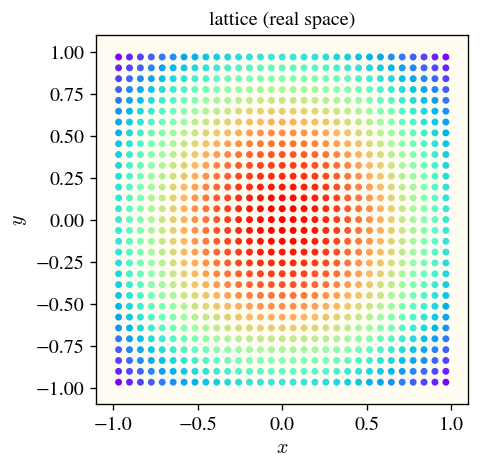

In [7]:
_, ax = plt.subplots(figsize=(4,4))
cval = np.cos(xx)*np.cos(yy)
cval = (cval-cval.min())/(cval.max()-cval.min())
lattice_colors = np.array(get_color(cval, cmap='rainbow'))
ax.scatter(xx, yy, c=lattice_colors, s=10)
ax.set_title("lattice (real space)")
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show()

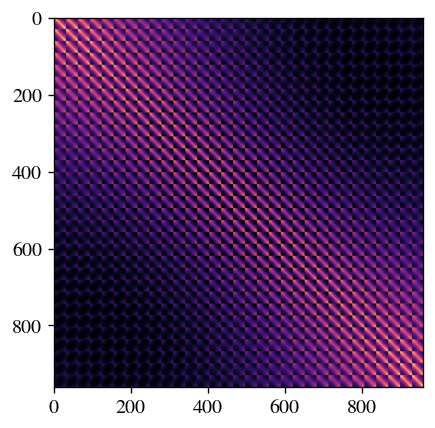

In [8]:
_, ax = plt.subplots(figsize=(4,4))

ax.imshow(M_th, cmap='magma')

plt.show()

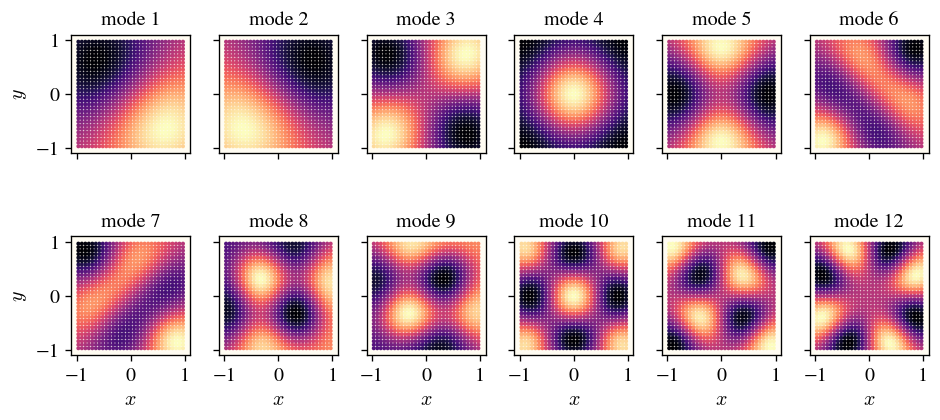

In [9]:
_, axes = plt.subplots(nrows=2, ncols=6, figsize=(8,4), sharex=True, sharey=True)
axes = axes.flat

idx_offset = 0
for i in range(12):
    ax = axes[i]
    cval = embeds[:, idx_offset+i]
    cval = (cval-cval.min())/(cval.max()-cval.min())
    eigv_colors = get_color(cval, cmap='magma')
    ax.scatter(xx, yy, c=eigv_colors, s=2)
    ax.set_title(f"mode {idx_offset+i+1}")
    if i in [0, 6]:
         ax.set_ylabel("$y$")
    if i in [6, 7, 8, 9, 10, 11]:
         ax.set_xlabel("$x$")
    ax.set_aspect('equal')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

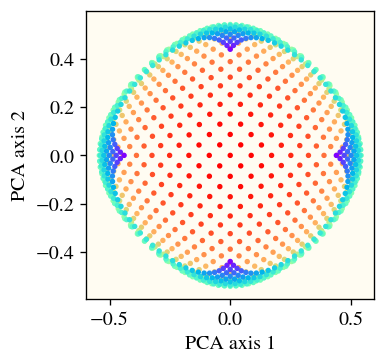

In [10]:
paint_order = np.argsort(np.sqrt(xx**2 + yy**2))
W = embeds.copy()[paint_order, :]
scatter_x = W[:, 0]
scatter_y = W[:, 1]
scatter_z = -W[:, 3]
colors = lattice_colors.copy()[paint_order, :]


fig = plt.figure(figsize=(4, 3))
left, right, top, bottom = 0.1, 0.98, 0.98, 0.18
gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)


ax = fig.add_subplot(gs[0, 0])
ax.scatter(scatter_x, scatter_y, c=colors, s=5)
ax.set_xlabel(f"PCA axis 1")
ax.set_ylabel(f"PCA axis 2")
ax.set_aspect("equal", "box")

plt.savefig("plots/appdx/lattice-embed-2d.png", dpi=300)

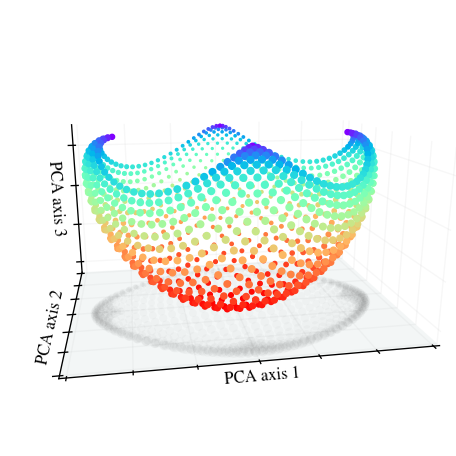

In [11]:
fig = plt.figure(figsize=(4, 3))
left, right, top, bottom = -0.1, 1.1, 1.1, -0.1
gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
ax = fig.add_subplot(gs[0, 0], projection='3d')
ss = 2*(scatter_y - scatter_y.min() + 0.08) * np.ones(len(colors))
ax.scatter(
    scatter_x, scatter_y, scatter_z,
    c=colors, s=7*ss, lw=0.9, alpha=1,
)

floor_z = np.full(len(scatter_x), scatter_z.min())
ax.scatter(
    scatter_x, scatter_y, floor_z,
    c="k", s=16*ss, lw=0, alpha=0.02
)

ax.set_proj_type('persp', focal_length=0.25)
ax.view_init(elev=15, azim=80)

ax.set_facecolor((1, 1, 1, 0))
ax.patch.set_alpha(0)
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.set_facecolor("#e9eeee")

ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
ax.set_zlim3d(scatter_z.min(), scatter_z.max())
ax.set_box_aspect((1.3, 1.0, 0.7))

plt.savefig("plots/appdx/lattice-embed-3d.png", dpi=300)
    

# Comparison with In-Context Learning of Representations

In [12]:
WIDTH = 1
FUNCTIONAL_FORM = lambda x: np.exp(-x/WIDTH)
PERIODIC_X = False
PERIODIC_Y = False
N_X = 4
N_Y = 4
N = N_X * N_Y
SUBSAMP = 0.

In [13]:
xmin, xmax = -(N_X-1)/N_X, (N_X-1)/N_X
xx = np.linspace(xmin, xmax, N_X, endpoint=True)
yy = np.linspace(xmin, xmax, N_Y, endpoint=True)
xx, yy = np.meshgrid(xx, yy)
xx = xx.ravel()
yy = yy.ravel()

dx = xx[:, None] - xx[None, :]
if PERIODIC_X:
    dx = np.abs((dx + 1) % 2 - 1)
else:
    dx = np.abs(dx)
  
dy = yy[:, None] - yy[None, :]
if PERIODIC_Y:
    dy = np.abs((dy + 1) % 2 - 1)
else:
    dy = np.abs(dy)

distances = np.sqrt(dx**2 + dy**2)

M_th = FUNCTIONAL_FORM(distances)

keep = (np.random.rand(N) >= SUBSAMP)
M_th = M_th[keep][:, keep]
centering = np.eye(N) - np.ones((N, N))/N
M_th = centering @ M_th @ centering.T
xx = xx[keep]
yy = yy[keep]
print(M_th.shape)

(16, 16)


In [14]:
embeds, signs = get_asym_embeds(M_th)

In [15]:
from scipy.spatial import cKDTree

pts = np.c_[xx, yy]
tree = cKDTree(pts)
d, _ = tree.query(pts, k=2)
a = np.min(d[:, 1])
pairs = tree.query_pairs(r=a * 1.001)


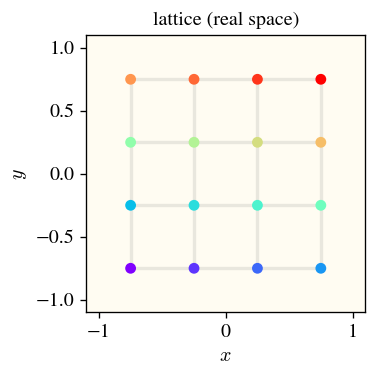

In [16]:
_, ax = plt.subplots(figsize=(3,3))
cval = xx + N_X*yy
cval = (cval-cval.min())/(cval.max()-cval.min())
lattice_colors = np.array(get_color(cval, cmap='rainbow'))
ax.scatter(xx, yy, c=lattice_colors, s=30)
for i, j in pairs:
    ax.plot([xx[i], xx[j]], [yy[i], yy[j]],
            c="xkcd:gray", lw=2, alpha=0.2, zorder=-4)
ax.set_title("lattice (real space)")
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.show()

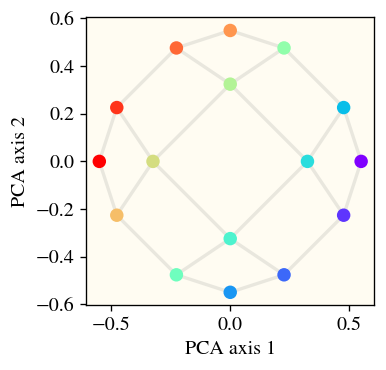

In [17]:
paint_order = np.argsort(np.sqrt(xx**2 + yy**2))
W = embeds.copy()#[paint_order, :]
scatter_x = W[:, 0]
scatter_y = W[:, 1]
scatter_z = -W[:, 3]
colors = lattice_colors.copy()#[paint_order, :]


fig = plt.figure(figsize=(4, 3))
left, right, top, bottom = 0.1, 0.98, 0.98, 0.18
gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)

ax = fig.add_subplot(gs[0, 0])
ax.scatter(scatter_x, scatter_y, c=colors, s=50)
for i, j in pairs:
    ax.plot([scatter_x[i], scatter_x[j]],
            [scatter_y[i], scatter_y[j]],
            c="xkcd:gray", lw=2, alpha=0.2, zorder=-4)
ax.set_xlabel(f"PCA axis 1")
ax.set_ylabel(f"PCA axis 2")
ax.set_aspect("equal", "box")

plt.savefig("plots/appdx/lattice-embed-2d-iclr.png", dpi=300)

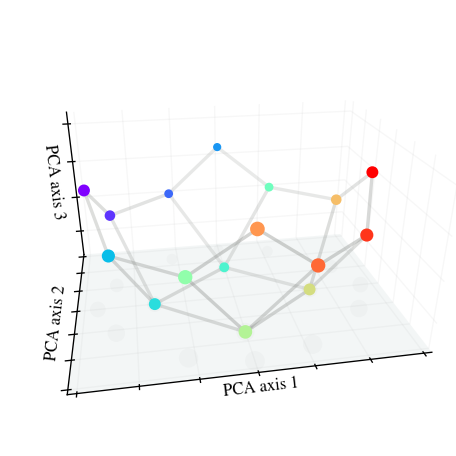

In [18]:
fig = plt.figure(figsize=(4, 3))
left, right, top, bottom = -0.1, 1.1, 1.1, -0.1
gs = fig.add_gridspec(1, 1, left=left, right=right, top=top, bottom=bottom)
ax = fig.add_subplot(gs[0, 0], projection='3d')
ss = 6*(scatter_y - scatter_y.min() + 0.38) * np.ones(len(colors))
ax.scatter(
    scatter_x, scatter_y, scatter_z,
    c=colors, s=7*ss, lw=0.9, alpha=1,
)

alphas = (ss / ss.max() + 0.4) * 0.3
for i, j in pairs:
    ax.plot([scatter_x[i], scatter_x[j]],
            [scatter_y[i], scatter_y[j]],
            [scatter_z[i], scatter_z[j]],
            c="xkcd:gray", lw=2, alpha=alphas[i])

floor_z = np.full(len(scatter_x), scatter_z.min())
ax.scatter(
    scatter_x, scatter_y, floor_z,
    c="k", s=16*ss, lw=0, alpha=0.02
)

ax.set_proj_type('persp', focal_length=0.25)
ax.view_init(elev=25, azim=80)

ax.set_facecolor((1, 1, 1, 0))
ax.patch.set_alpha(0)
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.set_facecolor("#e9eeee")

ax.xaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.yaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)
ax.zaxis._axinfo["grid"]["color"] = (0.7, 0.7, 0.7, 0.1)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel("PCA axis 1", labelpad=-15, fontsize=10)
ax.set_ylabel("PCA axis 2", labelpad=-12, fontsize=10)
ax.set_zlabel("PCA axis 3", labelpad=-10, fontsize=10)
ax.set_zlim3d(scatter_z.min(), scatter_z.max()+.2)
ax.set_box_aspect((1.3, 1.0, 0.7))

plt.savefig("plots/appdx/lattice-embed-3d-iclr.png", dpi=300)
    